# Laden von böntigeten Softwarebibliotheken und Festlegung von Grundeinstellungen

In [4]:
# Importieren von Bibliotheken die benötigt werden
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time

# Definiere Farben für Schaubilder
fh_teal = '#179c7d'
fh_orange = '#f29400'
fh_blue = '#1f82c0'
fh_red = '#e2001a'
fh_lightgreen = '#b1c800'
fh_beige = '#feefd6'
fh_grey = '#e1e3e3'

# Globale Einstellung für Schriftgröße, Farben usw. in Schaubildern
fh_palette = [fh_teal, fh_orange, fh_blue, fh_red, fh_lightgreen, fh_beige, fh_grey]
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette(fh_palette)
params = {'legend.fontsize': 22,
          'figure.figsize': (20, 14),
          'axes.labelsize': 22,
          'axes.titlesize': 26,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20}
mpl.rcParams.update(params)

# Initiale Exploration der Daten

In [5]:
# Festlegung der Namen der einzenlnen Merkmale (Spalten)
index = ['engine#','tCycles']
settings = ['setting1','setting2','setting3']
sensors = ['sensor' + str(i) for i in range(1,24)]
col_names = index + settings + sensors

In [6]:
# Laden der Trainingsdaten
df_train = pd.read_csv('./CMAPSSData/train_FD001.txt',sep=' ', names=col_names)

---
---
---
# Aufgabe 1
Nicht alle Sensoren liefern sinnvolle Informationen. Welche Sensoren sind das und sollten von der weiteren Analyse ausgeschlossen werden?
Hier können die Ergebnisse von Aufgabe 1.1 genommen werden. Die Daten und Sensoren können in den nächsten beiden Zeellen noch einmal betrachtet werden.

In [7]:
# Ein Blick auf die Trainingsdaten. Jede Zeile ist eine Beobachtung, jede Spalte ein Merkmal.
# Der Wert NaN (Abkürzung für: not a number) bedeutet, dass an dieser Stelle der Wert fehlt. 
df_train

,engine#,tCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [8]:
# Funktion, mit der in einem Schaubild der Sensorverlauf von mehreren Engines
# dargestellt werden kann
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in df_train['engine#'].unique():
        if (i % 20 == 0):
            plt.plot(np.arange(0, df_train[df_train['engine#']==i].shape[0]),
                     sensor_name,
                     data=df_train[df_train['engine#']==i])
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

In der nächsten Zelle kann noch einmal der Verlauf von Sensoren dargestellt werden. Hierfür für <font color='darkred'>engine#</font> durch den Namen eines anderen Merkmals ersetzen (Spalten in der Tabelle oberhalb). Die <font color='darkred'>' '</font> müssen stehen bleiben.


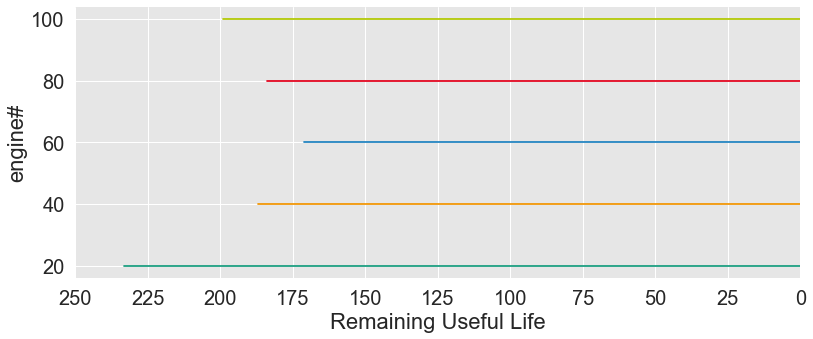

In [9]:
# Erstellen eines Schaubilds
plot_sensor('engine#')

# Ende Aufgabe 1
---
---
---

In der nächsten Zelle werden alle Merkmale, die keine Informationen oder Mehrwert liefern gelöscht. Dabei werden alle Merkmale (Spalten) gelöscht, die in der zweiten und dritten Zeile in der Zelle unterhalb stehen.

In [10]:
# Löschen von Merkmalen (Spalten), die keine Information beinhalten
drop_cols = ['setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor10',
             'sensor16', 'sensor18', 'sensor19', 'sensor22', 'sensor23']
df_train.drop(drop_cols,axis=1, inplace=True)

# Feature engineering / Merkmale konstruieren

### Erstellung der Restlaufdauer (Remaining Useful Lifetime, RUL)

In [11]:
# Definition der remaining useful lifetime (RUL)
def add_remaining_useful_life(df):
    # Erhalte die maximale Anzahl von Durchläufen pro Triebwerk (engine)
    grouped_by_unit = df_train.groupby(by="engine#")
    max_cycle = grouped_by_unit["tCycles"].max()
    
    # Erstelle eine neue Spalte "max_cycle", die die maximale Anzahl an Zyklus für jedes Triebwerk beinmhaltet
    result_frame = df_train.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine#', right_index=True)
    
    # Berechne die RUL für jede Beobachtung (Zeile)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["tCycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # Lösche die Spalte "max_cycle", da sie nicht Länger benötigt wird
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
df_train = add_remaining_useful_life(df_train)

In [12]:
# Zeige die Testdatenmatrix mit dem neuen Merkmal "RUL"
df_train

,engine#,tCycles,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [13]:
# Laden der Testdaten
df_test = pd.read_csv("./CMAPSSData/test_FD001.txt",sep=" ", names=col_names)
df_test.drop(drop_cols,axis=1, inplace=True)
df_test

,engine#,tCycles,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699


In [14]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### Erstelln von Trainings- und Testdatensatz
Die Testdaten und die Trainingsdaten werden jeweils in zwei Teile Aufgeteilt. Dabei ist X_train bzw. X_test immer der Datensatz, den der Algorithmus als Input bekommt und y_train bzw. y_test ist das Label, welches vom Algorithmus vorausgesagt werden soll.

In [15]:
# Erstelln von Trainings- und Testdatensatz
X_train = df_train.copy()
y_train = X_train.pop('RUL')


X_test = df_test.copy()
X_test = df_test.groupby('engine#').last().reset_index()

y_test = pd.read_csv(('./CMAPSSData/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# Modellierung

#### Importiere benötigte Bibliotheken und Funktionen für die Modellierung

In [16]:
import tensorflow.keras as tfk
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#### Normalisieren der Daten
Die Normalisierung der Daten wird für einige Algorithmen vorausgesetzt.

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Definition der Loss Function
Mit Hilfe dieser Funktion werden im folghenden die Algorithmen optimiert und können anhand der Größe des Fehler verglichen werden

In [18]:
def root_mean_squared_error(y_true, y_pred):
    return tfk.backend.sqrt(tfk.backend.mean(tfk.backend.square(y_pred - y_true)))

## Zum Start ein einfaches Modell / ein einfacher Algorithmus: Lineare Regression

In [19]:
# Definition des Modells / Algorithmus
model_linear = LinearRegression()

In [20]:
# Training des Modells / Algorithmus
model_linear.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
# Model Evaluation
y_hat_train = model_linear.predict(X_train_scaled)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = model_linear.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:39.58546827329525, R2:0.6697111890795342
test set RMSE:31.71973384242311, R2:0.4173610358106008


---
---
---
# Aufgabe 2
Der Fehler für das Trainingsset ist "train set RMSE", der Fehler des Testsets ist "test set RMSE". Es fällt auf, dass der Testfehler kleiner ist als der Trainingsfehler. Im Allgemeinen sollte dies genau umgekehrt sein.
<br>
<br>
Versuchen Sie folgende Fragen zu beantworten:
<br>
Warum ist der Trainingsfehler normalerweise kleiner als der Testfehler?

# Ende Aufgabe 2
---
---
---

# Genaue Betrachtung des RUL

---
---
---
# Aufgabe 3
Genaue Betrachtung der Restnutzungsdauer (RUL), die wie vorhin selbst erstellt haben.
<br>
Was fällt bei dieser auf?
<br>
Worin könnten Probleme liegen (Trainingsdaten vs. Testdaten)?

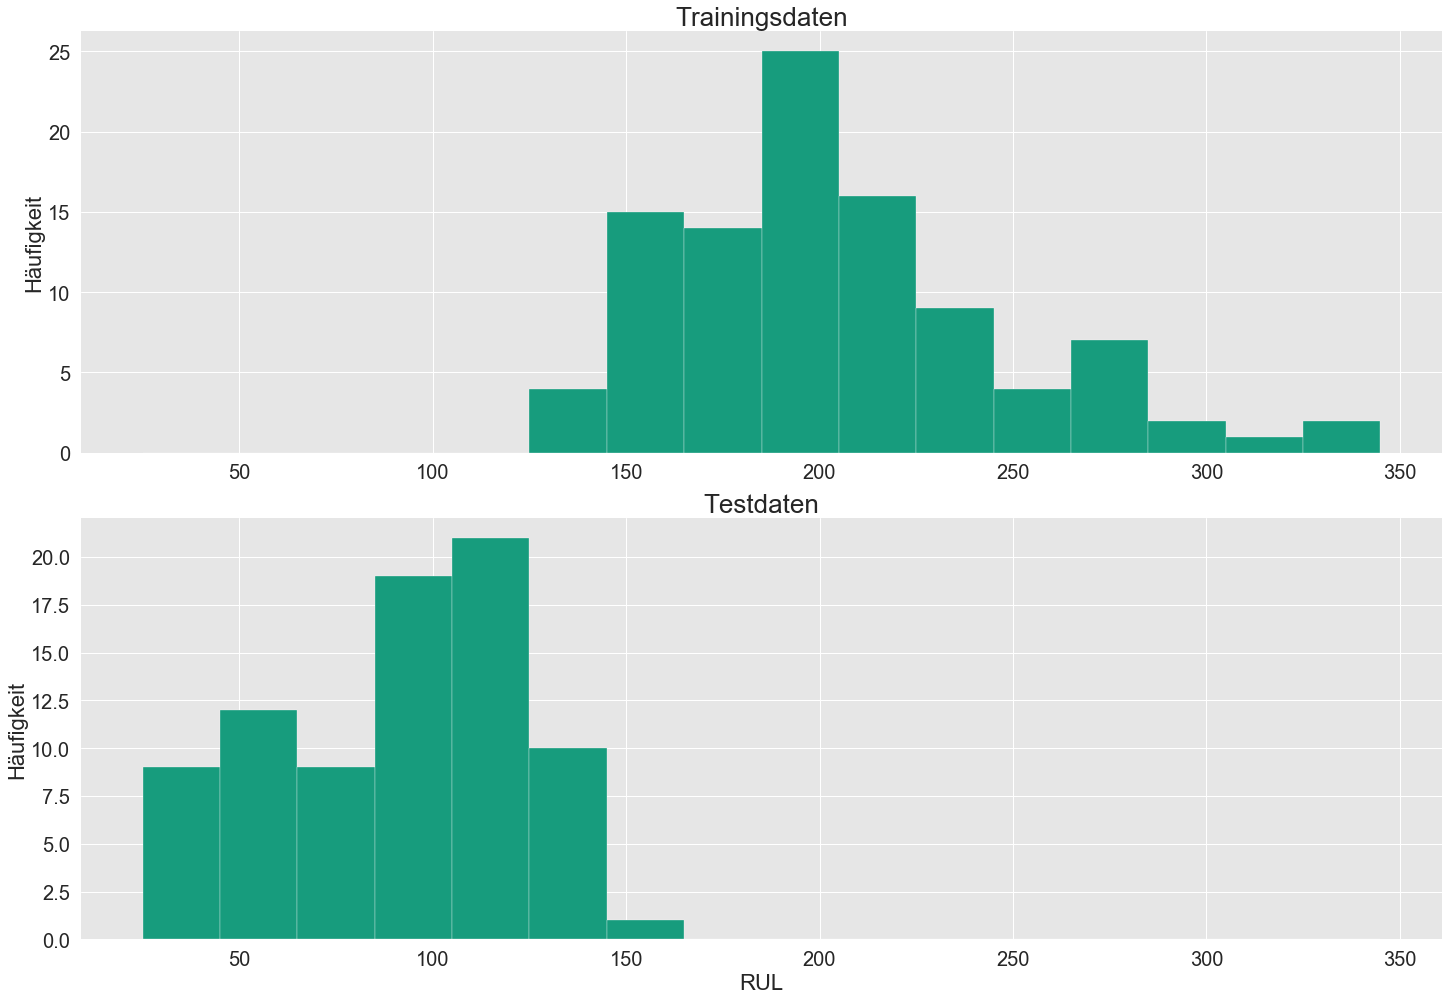

In [23]:
# Erstellen zweier Schaubilder. Diese zeigen die Verteilung der RUL im Trainings- und im Testdatensatz
df_max_rul = df_train[['engine#', 'RUL']].groupby('engine#').max().reset_index()

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(211)
df_max_rul['RUL'].hist(ax=ax, bins=range(25, 350, 20))
plt.ylabel('Häufigkeit')
plt.title('Trainingsdaten')

ax2 = fig.add_subplot(212)
y_test['RUL'].hist(ax=ax2, bins=range(25, 350, 20))
plt.xlabel('RUL')
plt.ylabel('Häufigkeit')
plt.title('Testdaten')
plt.show()

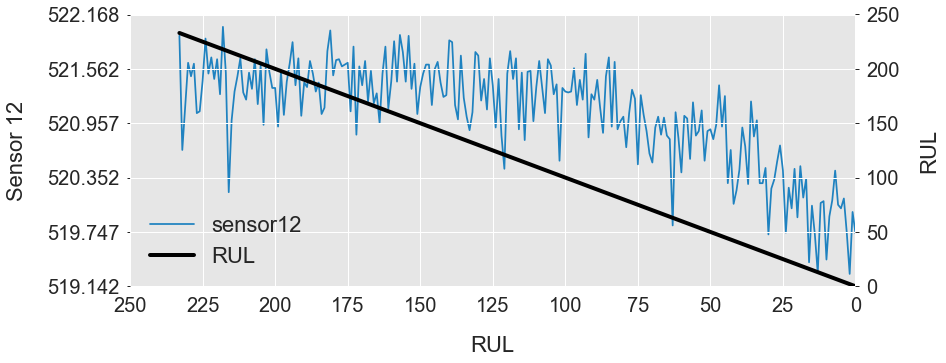

In [24]:
# Erstellung eines Schabilds, welches die RUL und einen beispielhaften Sensor für ein Triebwerk zeigt
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

unit20_RUL = np.array(df_train.loc[df_train['engine#']==20, 'RUL'])
unit20_sensor12 = np.array(df_train.loc[df_train['engine#']==20, 'sensor12'])

signal = ax1.plot(unit20_RUL, unit20_sensor12, color=fh_blue)

plt.xlim(250, 0)
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('Sensor 12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot(unit20_RUL, unit20_RUL, 'k', linewidth=4)
ax2.set_ylabel('RUL', labelpad=20)

ax2.set_ylim(0, 250)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))

lines = signal+rul_line
labels = ['sensor12', 'RUL']
ax1.legend(lines, labels, loc=0)

plt.show()

# Ende Aufgabe 3
---
---
---

# Erstellung einer besseren / optimierten Restlaufdauer 

In [25]:
# Berechnung der optimierten Restlaufdauer RUL 
y_train_optimized = y_train.clip(upper=125)

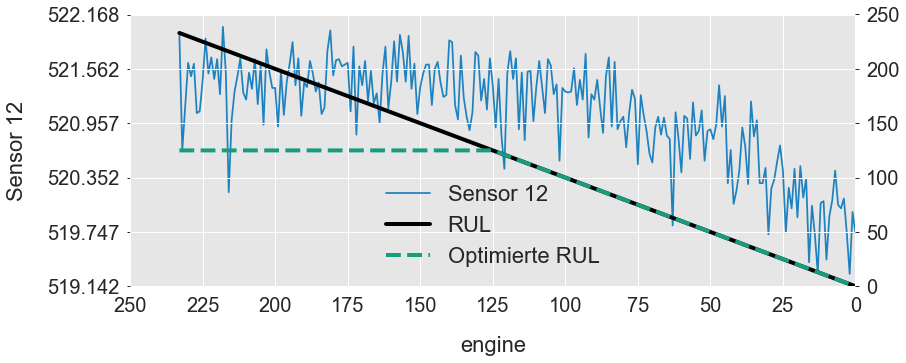

In [26]:
# Erstellung eines Schabilds, welches die RUL, die optimierte RUL und einen beispielhaften Sensor für ein Triebwerk zeigt
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot(unit20_RUL, unit20_sensor12, color=fh_blue)

rul = df_train.loc[df_train['engine#']==20, 'RUL']
unit20_RUL_optimized = unit20_RUL.copy()
unit20_RUL_optimized[unit20_RUL_optimized >= 125] = 125

plt.xlim(250, 0)
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('Sensor 12', labelpad=20)
ax1.set_xlabel('engine', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot(unit20_RUL, unit20_RUL, 'k', linewidth=4)

rul_line2 = ax2.plot(unit20_RUL, unit20_RUL_optimized, '--', linewidth=4, color=fh_teal)

ax2.set_ylim(0, 250)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))

lines = signal+rul_line+rul_line2
labels = ['Sensor 12', 'RUL', 'Optimierte RUL']
ax1.legend(lines, labels, loc=0)

#### Lineare Regression mit optimiertem RUL

In [27]:
# Model Definition
lm = LinearRegression()

# Model Training
lm.fit(X_train_scaled, y_train_optimized)

# Model Evaluation
y_hat_train = lm.predict(X_train_scaled)
evaluate(y_train_optimized, y_hat_train, 'train')
y_hat_test = lm.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:19.827954467105034, R2:0.773612325266579
test set RMSE:22.614038309741126, R2:0.7038602517095446


# Weitere Modelle

## Model Definition

### Definition eines Random Forest

In [28]:
model_forest = RandomForestClassifier(n_estimators=10)

### Definition eines Neural Network (Input Layer und Output Layer)

In [29]:
inputs = tfk.Input(shape=(18,))
outputs = tfk.layers.Dense(1, activation=tfk.activations.relu)(inputs)

model_nn = tfk.Model(inputs=inputs, outputs=outputs)
model_nn.compile(optimizer='rmsprop',loss = root_mean_squared_error)

### Definition eines Tiefen Neuronalen Netzes (Deep Neural Network; Input Layer, 3 Hidden Layer, Output Layer)

In [30]:
inputs = tfk.Input(shape=(18,))
x = tfk.layers.Dense(18, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(inputs)
x = tfk.layers.Dense(70, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(60, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(50, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(40, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(10,
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
outputs = tfk.layers.Dense(1,
                           activation=tfk.activations.relu,
                          activity_regularizer=tfk.regularizers.l1(0.00002))(x)

model_deep_nn = tfk.Model(inputs=inputs, outputs=outputs)
model_deep_nn.compile(optimizer=tfk.optimizers.RMSprop(learning_rate=0.01),
                      loss = root_mean_squared_error,
                     metrics=[root_mean_squared_error])

#### Definition einer Support Vector Maschine (SVM)

In [31]:
supVecMac = svm.SVR(kernel='linear')

# Model Training

### Training des Random Forest

In [32]:
model_forest.fit(X_train_scaled, y_train_optimized)
y_pred = model_forest.predict(X_train_scaled)
print('Trainingsfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_train_optimized, y_pred)))

Trainingsfehler (RMSE): 2.1133022124375636


### Training des Neural Network

In [33]:
model_nn.fit(X_train_scaled, y_train_optimized, batch_size=10, epochs=10)

Epoch 1/10
2064/2064 [==============================] - 1s 635us/step - loss: 87.1891
Epoch 2/10
2064/2064 [==============================] - 1s 621us/step - loss: 72.8858
Epoch 3/10
2064/2064 [==============================] - 1s 610us/step - loss: 60.7906
Epoch 4/10
2064/2064 [==============================] - 1s 605us/step - loss: 52.1396
Epoch 5/10
2064/2064 [==============================] - 1s 598us/step - loss: 47.3322
Epoch 6/10
2064/2064 [==============================] - 1s 597us/step - loss: 44.8823
Epoch 7/10
2064/2064 [==============================] - 1s 602us/step - loss: 43.1845
Epoch 8/10
2064/2064 [==============================] - 1s 618us/step - loss: 41.7237
Epoch 9/10
2064/2064 [==============================] - 1s 603us/step - loss: 40.3665
Epoch 10/10
2064/2064 [==============================] - 1s 647us/step - loss: 38.9980


### Training des Deep Neural Networks

In [34]:
model_deep_nn.fit(X_train_scaled, y_train_optimized, batch_size=10, epochs=10)

Epoch 1/10
2064/2064 [==============================] - 2s 1ms/step - loss: 21.9867 - root_mean_squared_error: 21.9711
Epoch 2/10
2064/2064 [==============================] - 2s 1ms/step - loss: 17.5527 - root_mean_squared_error: 17.5424
Epoch 3/10
2064/2064 [==============================] - 2s 1ms/step - loss: 16.8604 - root_mean_squared_error: 16.8498
Epoch 4/10
2064/2064 [==============================] - 2s 1ms/step - loss: 16.4529 - root_mean_squared_error: 16.4423A: 1s - loss: 16.6209 - root_me
Epoch 5/10
2064/2064 [==============================] - 3s 1ms/step - loss: 16.1046 - root_mean_squared_error: 16.0952
Epoch 6/10
2064/2064 [==============================] - 3s 1ms/step - loss: 15.8129 - root_mean_squared_error: 15.8031
Epoch 7/10
2064/2064 [==============================] - 3s 1ms/step - loss: 15.7430 - root_mean_squared_error: 15.7415
Epoch 8/10
2064/2064 [==============================] - 3s 1ms/step - loss: 15.5898 - root_mean_squared_error: 15.5844
Epoch 9/10
2064/2

### Training der Support Vector Machine

In [35]:
supVecMac.fit(X_train_scaled, y_train_optimized)
y_pred = supVecMac.predict(X_train_scaled)
print('Trainingsfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_train_optimized, y_pred)))

Trainingsfehler (RMSE): 19.863088515644268


# Model Evaluation & vergleich aller Modelle

In [36]:
model_linear = linear_model.LinearRegression()
model_linear.fit(X_train_scaled, y_train_optimized)

models = [model_linear, model_forest, model_nn, model_deep_nn, supVecMac]

metric = metrics.mean_squared_error
metric_per_model = []
for model in models:
    prediction = model.predict(X_test_scaled)
    cost = metric(y_test, prediction)
    cost = np.sqrt(cost)
    metric_per_model.append(cost)
    


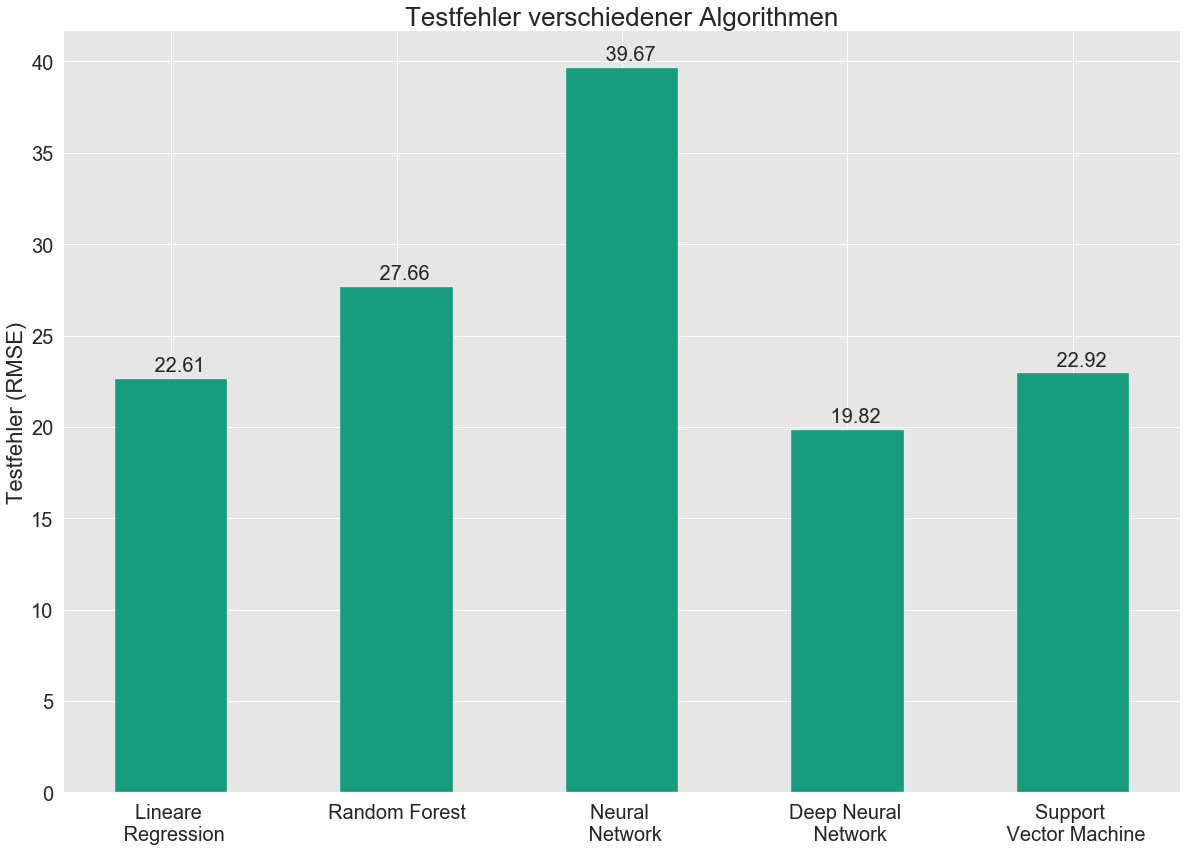

In [37]:
x = np.arange(len(metric_per_model))
model_names = ['Lineare \n Regression', 'Random Forest', 'Neural \n Network', 'Deep Neural \n Network', 'Support \n Vector Machine']


fig, ax = plt.subplots()
bar = ax.bar(x, metric_per_model, .5)
plt.xticks(x,[model for model in model_names])

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., .2 + height,
            '%8.2f' % height,
            ha='center', va='bottom',
            fontsize=20)

plt.title('Testfehler verschiedener Algorithmen')
plt.ylabel('Testfehler (RMSE)');

# Hyperparameter-Optimierung (Hyperparamter tunining)

---
---
---
# Aufgabe 4
Welches sind die optimaten Hyperparamter für einen Random Forest?
<br>
Versuche verschiedene Hyperparametr aus. Dabei können in der nächsten Zelle die folgenden Hyperparameter angepasst werden:
<br>
<b>n_estimator:</b> Anzahl der Bäume (ganze Zahl zwischen 2 und 100. Je höher die Zahl, desto länger dauert die Berechnung)
<br>
<b>max_depth:</b> Maximale Tiefe eines Baumes (ganze Zahl zwischen 2 und 15 oder None, falls keine maximale Tiefe vorgegebn werden soll)
<br>
<b>max_features:</b> Maximale Anzhal der Merkmale, die für das erstellen eines Baumes zufällig ausgewählt wertden (ganze Zahl zwischen 2 und 15 oder “auto”, “sqrt”, “log2”. Der Standardwert ist sqrt(n_features), die Quadratwurzel der Anzahl der Merkmale)
<br>
Es gibt noch viele weitere...

In [38]:
# Definition des Random Forests
model_forest = RandomForestClassifier(n_estimators=10, max_depth=None, max_features='sqrt')

In [39]:
# Training des Random Forests
model_forest.fit(X_train_scaled, y_train_optimized)
y_pred = model_forest.predict(X_train_scaled)
print('Trainingsfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_train_optimized, y_pred)))

Trainingsfehler (RMSE): 1.8281959472921678


# Ende Aufgabe 4
---
---
---

# Zufällige Suche (Random Search) der optimalen Hyperparamter für einen Random Forest

In [40]:
# Erstellen der Random Search mit Angabe, welche Hyperparameter mit welchen werten getestet werden sollen
def Random_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10, 25, 50, 100, 250, 500],
            "max_features"      : ["sqrt", "log2"],
            "min_samples_split" : [2,4,8,16, 32],
            "bootstrap": [True, False]
            }

    random_params = RandomizedSearchCV(estimator, param_grid, n_iter=20, n_jobs=-1, cv=5)

    random_params.fit(X_train, y_train)

    return random_params.best_score_ , random_params.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    return y_test,y_predict

In [ ]:
# Durchführen der Random Search für den Random Forest
best_score, best_params = Random_Search_CV_RFR(X_train_scaled, y_train_optimized)
y_test , y_predict = RFR(X_train_scaled, X_test_scaled, y_train_optimized, y_test, best_params)
print("Best params:",best_params)

### Der Random Forest mit den optimalen Hyperparametern

In [ ]:
# Der Random Forest mit den optimalen Hyperparametern wird nun noch einmal mit allen Daten trainiert
model_forest2 = RandomForestClassifier(bootstrap=True, max_features='log2', n_estimators=100)
model_forest2.fit(X_train_scaled, y_train_optimized)
y_pred = model_forest2.predict(X_train_scaled)

In [ ]:
# Testfehler des Random Forest mit den optimalen Hyperparametern
y_pred = model_forest2.predict(X_test_scaled)
print('Testfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Vergleich aller Modelle

In [ ]:
models2 = [model_linear, model_forest, model_forest2, model_nn, model_deep_nn, supVecMac]

metric = metrics.mean_squared_error
metric_per_model2 = []
for model in models2:
    prediction = model.predict(X_test_scaled)
    cost = metric(y_test, prediction)
    cost = np.sqrt(cost)
    metric_per_model2.append(cost)

In [ ]:
x = np.arange(len(metric_per_model2))
model_names2 = ['Lineare \n Regression', 'Random Forest', 'Optimierter  \n Random Forest', 'Neural \n Network', 'Deep Neural \n Network', 'Support \n Vector Machine']


fig, ax = plt.subplots()
bar = ax.bar(x, metric_per_model2, .5)
plt.xticks(x,[model for model in model_names2])

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., .2 + height,
            '%8.2f' % height,
            ha='center', va='bottom',
            fontsize=20)

plt.title('Testfehler verschiedener Algorithmen')
plt.ylabel('Testfehler (RMSE)');